Regressionanalysis

Step 1: Load and inspect the data

In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.stattools import durbin_watson
from scipy.stats import shapiro
import itertools


In [6]:

file_path = 'scraped_data/wggesucht_cleaned.csv'
data = pd.read_csv(file_path)

# Display the first few rows of the dataset
display(data.head())
print(data.shape)

,PriceTotal,Size,Deposit,OnlineSince,Adress,AmountofIcons,AmountofIconsNeeded,Title_length,LookingFor_length,analysis_det,analysis_desr,analysis_desl,analysis_desli,analysis_deso
0,670,12,0,1.0,3,3,0,38,338,0.4588,0.0000,-0.2960,0.8625,0.0772
1,350,20,600,1.0,4,12,0,48,245,0.0000,0.0000,0.2023,-0.9020,-0.5994
2,790,11,2200,1.0,3,8,4,42,16,0.0000,0.8122,0.3804,0.3400,0.0000
3,970,14,2673,1.0,3,7,3,46,16,0.0000,-0.9097,-0.9823,0.0000,0.0000
4,800,14,2145,1.0,3,12,5,52,16,0.0000,-0.5255,-0.9955,0.0000,0.0000


(1135, 14)


**Initial estimates:**

**Size correlates positively:** Larger apartments tend to be more expensive, especially since rent is often calculated by the formula: size * price per unit = rent price.

**Deposit correlates positively:** A larger deposit might indicate a more expensive apartment, which could require a higher monthly rent.

**OnlineSince correlates positively:** Cheaper apartments or good deals might not be online anymore. Thus, longer advertised apartments might be unjustifiably expensive.

**Address correlates positively:** A better address category reflects a more expensive area in the city of Munich.

**Amount of Icons/Title length:** These might also correlate positively since an advert with more detail might indicate the author took more time to write it, suggesting they might charge a premium or be an "institutional" actor.

**LookingFor length:** This might be correlated negatively. If the author writes a lot in this section, it may indicate they restrict a lot of potential candidates, leading to less demand and thus a lower price.

**Sentiment analysis of the description texts:** This should correlate positively since a nice description reflects more effort being made by the author, which could indicate a higher price.






Step 2: Create a correlation matrix


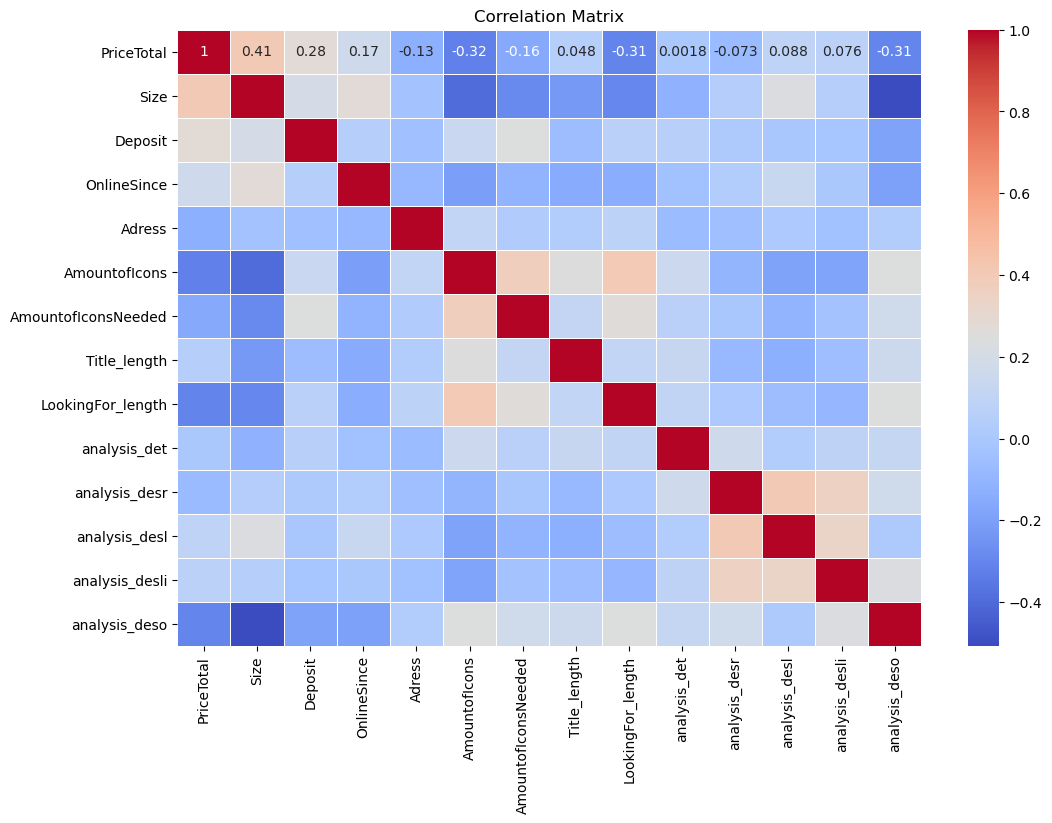

In [7]:
# Calculate the correlation matrix
correlation_matrix = data.corr()

# Plot the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()

Step 3: Simple regression model: PriceTotal vs. Size


In [8]:

# Simple regression model
X_simple = data['Size']
y = data['PriceTotal']
X_simple = sm.add_constant(X_simple)
model_simple = sm.OLS(y, X_simple).fit()
print(model_simple.summary())



                            OLS Regression Results                            
Dep. Variable:             PriceTotal   R-squared:                       0.167
Model:                            OLS   Adj. R-squared:                  0.166
Method:                 Least Squares   F-statistic:                     227.1
Date:                Wed, 03 Jul 2024   Prob (F-statistic):           6.54e-47
Time:                        12:59:07   Log-Likelihood:                -7717.0
No. Observations:                1135   AIC:                         1.544e+04
Df Residuals:                    1133   BIC:                         1.545e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        739.6354      8.464     87.382      0.0

reality = model + error

R^2: only 0.167 (ideal close to 1 since it covers the model/reality => closer to 1 the more it reflects to reality)

F-statistics: 227.1 (the larger the better => ideally over 1 but then the pure number itself is not really interpretable model/error)


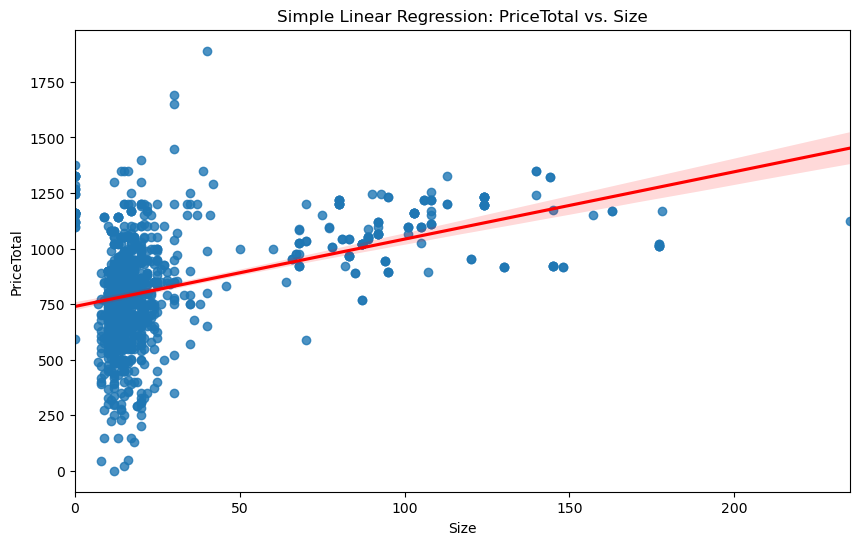

In [9]:
# Plot the simple regression model
plt.figure(figsize=(10, 6))
sns.regplot(x='Size', y='PriceTotal', data=data, line_kws={'color': 'red'})
plt.title('Simple Linear Regression: PriceTotal vs. Size')
plt.xlabel('Size')
plt.ylabel('PriceTotal')
plt.show()

Step 4: Multiple regression models: PriceTotal vs. all independent variables


In [10]:
# Multiple regression models
X = data.drop(columns=['PriceTotal'])
y = data['PriceTotal']
X = sm.add_constant(X)
model_multiple = sm.OLS(y, X).fit()
print(model_multiple.summary())


                            OLS Regression Results                            
Dep. Variable:             PriceTotal   R-squared:                       0.353
Model:                            OLS   Adj. R-squared:                  0.345
Method:                 Least Squares   F-statistic:                     47.02
Date:                Wed, 03 Jul 2024   Prob (F-statistic):           1.80e-96
Time:                        12:59:07   Log-Likelihood:                -7573.7
No. Observations:                1135   AIC:                         1.518e+04
Df Residuals:                    1121   BIC:                         1.525e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                 723.7158    

On the search for a better model, focus on the R-squared values.


Interesting enough: It finds the full spec model with every data column involved.

In [11]:
def find_best_model(data, dependent_var):
    # Separate the dependent variable and independent variables
    y = data[dependent_var]
    X = data.drop(columns=[dependent_var])
    X = sm.add_constant(X)
    
    # Initialize variables to store the best model
    best_r_squared = -1
    best_model = None
    best_combination = None
    
    # Iterate over all combinations of independent variables
    for i in range(1, len(X.columns)):
        for combo in itertools.combinations(X.columns[1:], i):
            X_subset = X[['const'] + list(combo)]
            model = sm.OLS(y, X_subset).fit()
            r_squared = model.rsquared
            
            # Update the best model if current model is better
            if r_squared > best_r_squared:
                best_r_squared = r_squared
                best_model = model
                best_combination = combo
    
    return best_model, best_combination, best_r_squared

# Example usage
data = pd.read_csv(file_path)

# Find the best model for 'PriceTotal'
best_model, best_combination, best_r_squared = find_best_model(data, 'PriceTotal')
print(f"Best R-squared: {best_r_squared}")
print(f"Best combination of independent variables: {best_combination}")
print(best_model.summary())

Best R-squared: 0.35285968230653
Best combination of independent variables: ('Size', 'Deposit', 'OnlineSince', 'Adress', 'AmountofIcons', 'AmountofIconsNeeded', 'Title_length', 'LookingFor_length', 'analysis_det', 'analysis_desr', 'analysis_desl', 'analysis_desli', 'analysis_deso')
                            OLS Regression Results                            
Dep. Variable:             PriceTotal   R-squared:                       0.353
Model:                            OLS   Adj. R-squared:                  0.345
Method:                 Least Squares   F-statistic:                     47.02
Date:                Wed, 03 Jul 2024   Prob (F-statistic):           1.80e-96
Time:                        12:59:15   Log-Likelihood:                -7573.7
No. Observations:                1135   AIC:                         1.518e+04
Df Residuals:                    1121   BIC:                         1.525e+04
Df Model:                          13                                         
Covari

Now, a similar algorithm penalizes having too many explanatory variables at a 0.02 level.

In [12]:
def find_best_model(data, dependent_var):
    # Separate the dependent variable and independent variables
    y = data[dependent_var]
    X = data.drop(columns=[dependent_var])
    X = sm.add_constant(X)
    
    # Initialize variables to store the best model
    best_r_squared = -1
    best_model = None
    best_combination = None
    best_num_vars = float('inf')
    current_subset = None
    
    # Iterate over all combinations of independent variables
    for i in range(1, len(X.columns)):
        for combo in itertools.combinations(X.columns[1:], i):
            X_subset = X[['const'] + list(combo)]
            model = sm.OLS(y, X_subset).fit()
            r_squared = model.rsquared
            # Update the best model if current model is better
            if (r_squared  > best_r_squared+ 0.02) or (r_squared >= best_r_squared - 0.02 and len(combo) < best_num_vars):
                best_r_squared = r_squared
                best_model = model
                best_combination = combo
                best_num_vars = len(combo)
                current_subset = X_subset
    
    return best_model, best_combination, best_r_squared, current_subset

# Example usage
data = pd.read_csv(file_path)

# Find the best model for 'PriceTotal'
best_model, best_combination, best_r_squared, X_Best = find_best_model(data, 'PriceTotal')
print(f"Best R-squared: {best_r_squared}")
print(f"Best combination of independent variables: {best_combination}")
print(best_model.summary())


Best R-squared: 0.3437370085673489
Best combination of independent variables: ('Size', 'Deposit', 'OnlineSince', 'Adress', 'AmountofIcons', 'Title_length', 'LookingFor_length', 'analysis_det', 'analysis_desr')
                            OLS Regression Results                            
Dep. Variable:             PriceTotal   R-squared:                       0.344
Model:                            OLS   Adj. R-squared:                  0.338
Method:                 Least Squares   F-statistic:                     65.47
Date:                Wed, 03 Jul 2024   Prob (F-statistic):           1.13e-96
Time:                        12:59:22   Log-Likelihood:                -7581.6
No. Observations:                1135   AIC:                         1.518e+04
Df Residuals:                    1125   BIC:                         1.523e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         


Although there is a minor loss of quality in the model by 0.015, we now have a way smaller model with some of the more non explainatory values excluded.

Step 6: Check assumptions

1. Correct model specification
The model specification is based on theoretical considerations and prior research.

2. No perfect multicollinearity
Multicollinearity is checked using VIF values. VIF values below 5 indicate no serious multicollinearity.

In [20]:
print("VIF Values:\n")
vif_data = pd.DataFrame()
vif_data['Feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print("Model 1:\n", vif_data)


vif_data = pd.DataFrame()
vif_data['Feature'] = X_Best.columns
vif_data['VIF'] = [variance_inflation_factor(X_Best.values, i) for i in range(X_Best.shape[1])]
print("Model 2:\n", vif_data)


VIF Values:

Model 1:
                 Feature        VIF
0                 const  14.876183
1                  Size   1.776242
2               Deposit   1.232309
3           OnlineSince   1.117100
4                Adress   1.033378
5         AmountofIcons   1.581132
6   AmountofIconsNeeded   1.299710
7          Title_length   1.117471
8     LookingFor_length   1.267270
9          analysis_det   1.090542
10        analysis_desr   1.350519
11        analysis_desl   1.354130
12       analysis_desli   1.322187
13        analysis_deso   1.590362
Model 2:
              Feature        VIF
0              const  14.334848
1               Size   1.401849
2            Deposit   1.124218
3        OnlineSince   1.106040
4             Adress   1.030909
5      AmountofIcons   1.480738
6       Title_length   1.113014
7  LookingFor_length   1.236214
8       analysis_det   1.086669
9      analysis_desr   1.057180


c:\Users\Gero\anaconda3\Lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


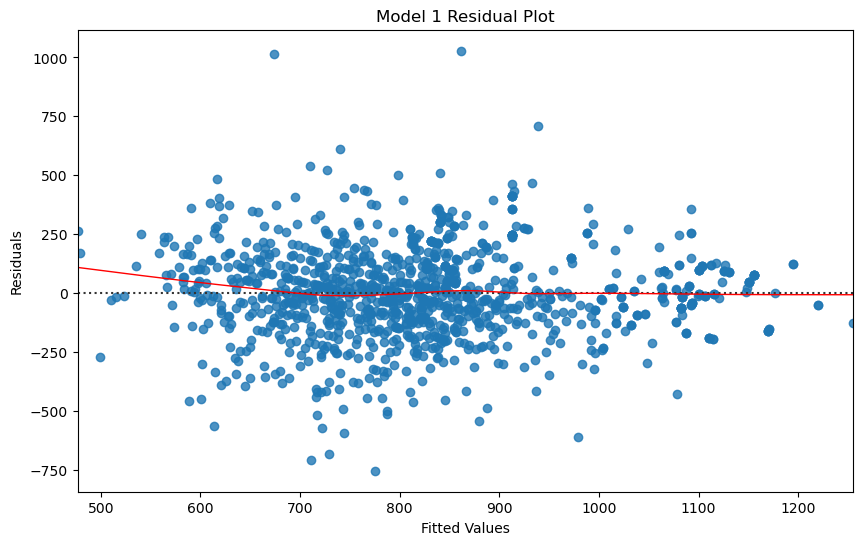

<Figure size 1000x600 with 0 Axes>

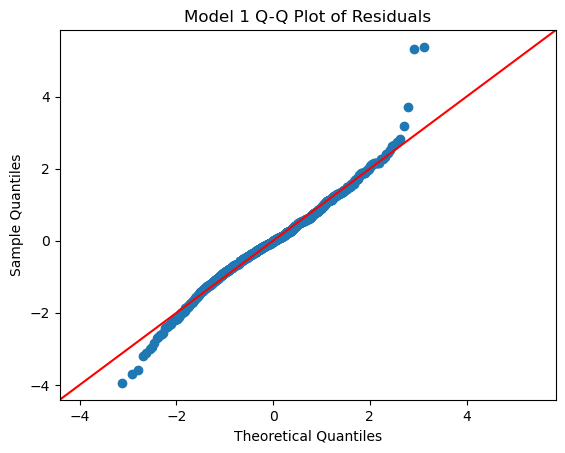

In [21]:
# Residual plot for the multiple regression model
fitted_values = model_multiple.fittedvalues
plt.figure(figsize=(10, 6))
sns.residplot(fitted_values, model_multiple.resid, lowess=True, line_kws={'color': 'red', 'lw': 1})
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Model 1 Residual Plot')
plt.show()

# Create the Q-Q plot
plt.figure(figsize=(10, 6))
sm.qqplot(model_multiple.resid, line='45', fit=True)
plt.title('Model 1 Q-Q Plot of Residuals')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')
plt.show()

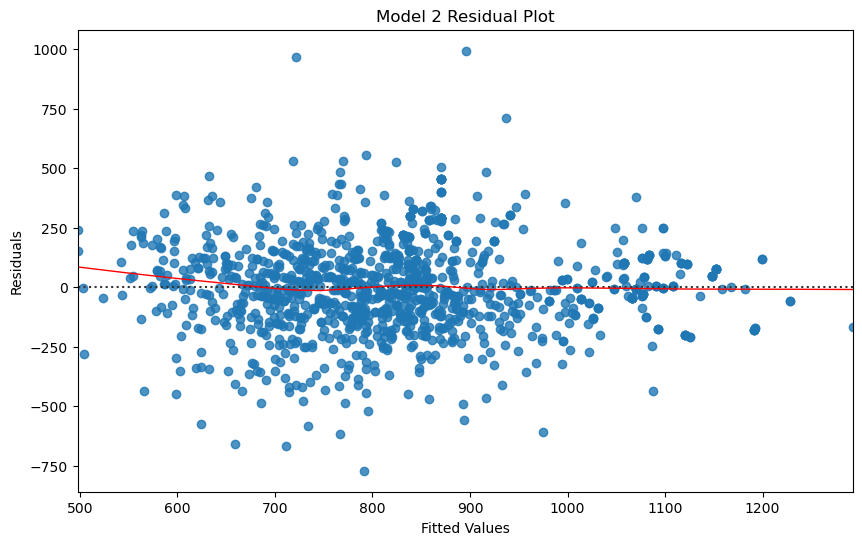

<Figure size 1000x600 with 0 Axes>

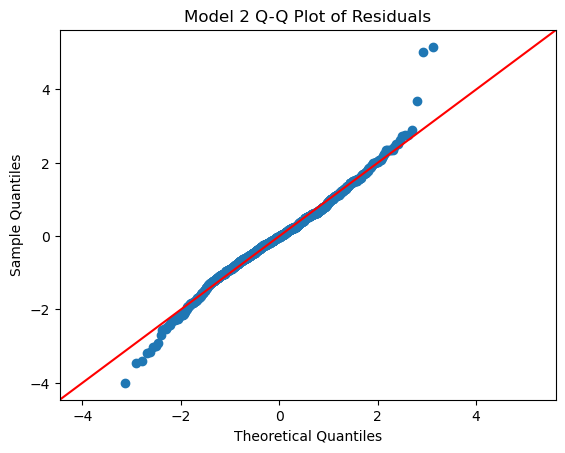

In [22]:
# Residual plot for the multiple regression model
fitted_values = best_model.fittedvalues
plt.figure(figsize=(10, 6))
sns.residplot(fitted_values, best_model.resid, lowess=True, line_kws={'color': 'red', 'lw': 1})
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Model 2 Residual Plot')
plt.show()

# Create the Q-Q plot
plt.figure(figsize=(10, 6))
sm.qqplot(best_model.resid, line='45', fit=True)
plt.title('Model 2 Q-Q Plot of Residuals')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')
plt.show()

3. Expected value of the error is zero
Check the mean of the residuals:

In [23]:
# Mean of residuals
print("Mean of residuals:\n")
mean_residuals = model_multiple.resid.mean()
print("Model 1: ", mean_residuals)

mean_residuals = best_model.resid.mean()
print("Model 2: ", mean_residuals)



Mean of residuals:

Model 1:  1.2686850102043953e-12
Model 2:  2.032139703697045e-12


4. Homoscedasticity
Check graphically or using the Breusch-Pagan test => p < 0.05 Level (when below then we reject the Homoscedasticity presents):


In [24]:
print("Breusch-Pagan test p-value: \n")
bp_test = het_breuschpagan(model_multiple.resid, model_multiple.model.exog)
print("Model 1", bp_test[1])

bp_test = het_breuschpagan(best_model.resid, best_model.model.exog)
print("Model 2", bp_test[1])


Breusch-Pagan test p-value: 

Model 1 4.43868233159251e-11
Model 2 6.200595574638538e-09


5. No correlation between independent variables and error term
This assumption is theoretical and requires ensuring no omitted variable bias.



6. No autocorrelation
Use the Durbin-Watson test:

The Durbin-Watson statistic ranges from 0 to 4:

DW ≈ 2: Indicates no autocorrelation.
DW < 2: Indicates positive autocorrelation.
DW > 2: Indicates negative autocorrelation.

In [25]:
print("Durbin-Watson test statistic:\n")
dw_test = durbin_watson(model_multiple.resid)
print("Model 1: ", dw_test)


dw_test = durbin_watson(best_model.resid)
print("Model 2: ", dw_test)


Durbin-Watson test statistic:

Model 1:  1.8911853372223815
Model 2:  1.8627525969620367


slightly positive autocorrelation, close to 2

7. Errors are normally distributed
Check graphically or using the Shapiro-Wilk test:

Shapiro-Wilk Test statistic: If this value is close to 1, indicating that the residuals are likely to be normally distributed.
p-value: This is the p-value associated with the test statistic. A low p-value (typically less than 0.05) suggests that the residuals are not normally distributed.

In [26]:
import scipy.stats as stats

# Get the residuals from the model
residuals = model_multiple.resid

# Perform the Shapiro-Wilk test
shapiro_test = stats.shapiro(residuals)

# Print the test results
print("Model 1:")
print('Shapiro-Wilk Test statistic:', shapiro_test.statistic)
print('p-value:', shapiro_test.pvalue)

# Get the residuals from the model
residuals = best_model.resid

# Perform the Shapiro-Wilk test
shapiro_test = stats.shapiro(residuals)

# Print the test results
print("\nModel 2:")
print('Shapiro-Wilk Test statistic:', shapiro_test.statistic)
print('p-value:', shapiro_test.pvalue)


Model 1:
Shapiro-Wilk Test statistic: 0.9832797646522522
p-value: 3.855007979503e-10

Model 2:
Shapiro-Wilk Test statistic: 0.9860630631446838
p-value: 6.0765299458864774e-09


The test statistics value is close to 1 which indicates a normal distribution of residuals, but the low p values suggests a not normal distribution. Therefore the models fail the shapiro Wilk test.

**Conclusion:**

Ultimatly the models did not pass all tests, so the model isn't great yet, also indicated by the low R^2 of ~ 0.35. Therefore it comes apperent that factors of price influence on the wggesucht.de website might not be found on the advert itself but are determined by other factors e.g.
- greater economic concepts
- the landlords fluctuation in price determination
- specification of the apartment which coulnd'nt be mined by my clean_up_data file or aren't indicated on the wggesucht.de website (e.g. noise levels)
- ...
